In [1]:
import matplotlib
# Temporary compatibility patch for SHAP + Matplotlib 3.9+
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

data_path = "/work/siads_699_mads_capstone/data/models/workzone_features.csv"
df = pd.read_csv(data_path)
print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

def clean_bracketed(val):
    if isinstance(val, str):
        val = val.strip("[]")
        try:
            return float(val)
        except:
            return np.nan
    return val

for c in df.columns:
    if df[c].dtype == "object" and c not in ["road_event_id", "road_name", "vehicle_impact"]:
        df[c] = df[c].apply(clean_bracketed)

agg_cols = [
    'duration_hr','avg_distance_km','avg_visibility_mi','avg_precip_in',
    'avg_temp_F','avg_wind_mph','crash_count','high_risk'
]
df_unique = (
    df.groupby('road_event_id', as_index=False)[agg_cols].agg({
        'duration_hr': 'mean',
        'avg_distance_km': 'mean',
        'avg_visibility_mi': 'mean',
        'avg_precip_in': 'mean',
        'avg_temp_F': 'mean',
        'avg_wind_mph': 'mean',
        'crash_count': 'sum',
        'high_risk': 'max'
    })
)
print(f"Aggregated: {df_unique.shape[0]} unique work-zone records")

feature_cols = [
    'duration_hr','avg_distance_km','avg_visibility_mi',
    'avg_precip_in','avg_temp_F','avg_wind_mph'
]
X = df_unique[feature_cols].fillna(0).astype(np.float32)
y = df_unique['high_risk'].astype(int)

print(f"Feature shape: {X.shape}, Positive class share: {y.mean():.2f}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

xgb_base = XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    eval_metric="auc", random_state=42
)
xgb_base.fit(X_train, y_train)
y_pred = xgb_base.predict_proba(X_test)[:,1]
auc_base = roc_auc_score(y_test, y_pred)
f1_base = f1_score(y_test, (y_pred > 0.5).astype(int))
print(f"\nBaseline AUC={auc_base:.3f}, F1={f1_base:.3f}")

Loaded dataset: 1653 rows, 14 columns
Aggregated: 1653 unique work-zone records
Feature shape: (1653, 6), Positive class share: 0.25

Baseline AUC=1.000, F1=0.994


In [3]:
#Group Kfold validation
groups = df_unique['road_event_id'].fillna('unknown').astype(str)
unique_groups = len(np.unique(groups))
print(f"\nGroupKFold unique groups: {unique_groups}")

if unique_groups >= 5:
    gkf = GroupKFold(n_splits=5)
    group_auc = cross_val_score(xgb_base, X, y, cv=gkf.split(X, y, groups), scoring='roc_auc')
    print("GroupKFold AUCs:", np.round(group_auc,3))
    auc_group = group_auc.mean()
else:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    group_auc = cross_val_score(xgb_base, X, y, cv=skf, scoring='roc_auc')
    auc_group = group_auc.mean()
print("Group Validation Mean AUC:", round(auc_group,3))


GroupKFold unique groups: 1653
GroupKFold AUCs: [0.999 1.    1.    1.    1.   ]
Group Validation Mean AUC: 1.0


In [4]:
#Tempral
X_sorted = X.copy()
X_sorted['time_order'] = np.arange(len(X_sorted))
train_idx = X_sorted['time_order'] < int(0.8*len(X_sorted))
test_idx  = ~train_idx
xgb_base.fit(X_sorted.loc[train_idx, feature_cols], y[train_idx])
y_temp_pred = xgb_base.predict_proba(X_sorted.loc[test_idx, feature_cols])[:,1]
auc_temp = roc_auc_score(y[test_idx], y_temp_pred)
print("Temporal Validation AUC:", round(auc_temp,3))

Temporal Validation AUC: 0.732


In [5]:
#Permutation
y_perm = np.random.permutation(y)
xgb_base.fit(X, y_perm)
y_perm_pred = xgb_base.predict_proba(X)[:,1]
auc_perm = roc_auc_score(y_perm, y_perm_pred)
print("Permutation AUC:", round(auc_perm,3))

Permutation AUC: 0.726


In [6]:
#Feature shuffle
X_shuff = X.sample(frac=1, replace=False, random_state=42).reset_index(drop=True)
xgb_base.fit(X_shuff, y)
y_shuff_pred = xgb_base.predict_proba(X_shuff)[:,1]
auc_shuff = roc_auc_score(y, y_shuff_pred)
print("Feature-shuffled AUC:", round(auc_shuff,3))

Feature-shuffled AUC: 0.701


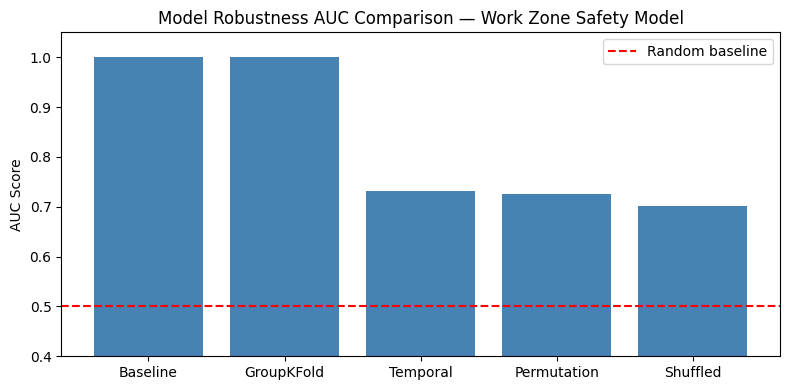

Baseline            : 1.000
GroupKFold          : 1.000
Temporal            : 0.732
Permutation         : 0.726
Shuffled            : 0.701


In [7]:
#visualization
results = {
    "Baseline": auc_base,
    "GroupKFold": auc_group,
    "Temporal": auc_temp,
    "Permutation": auc_perm,
    "Shuffled": auc_shuff
}

plt.figure(figsize=(8,4))
plt.bar(results.keys(), results.values(), color='steelblue')
plt.axhline(0.5, color='red', linestyle='--', label='Random baseline')
plt.title("Model Robustness AUC Comparison — Work Zone Safety Model")
plt.ylabel("AUC Score")
plt.ylim(0.4, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

for k,v in results.items():
    print(f"{k:20s}: {v:.3f}")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=609edc76-98cb-4265-b05f-b8bb14bd7d7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>